In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.setfit_trainer import SetFitTrainer
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [19]:
!mkdir logs
model_name = "SetFit"
dataset_name = "AG_news"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## SetFit

In [15]:
embedding_model = SentenceTransformer("peulsilva/phrase-bert-setfit-300shots-yahoo_answers",
                            cache_folder = '/Data/pedro.silva/')

In [6]:
try:
    from torch.hub import _get_torch_home

    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(os.getenv('TORCH_HOME', os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))

cache_folder = os.path.join(torch_cache_home, 'sentence_transformers')

## Loading AGnews data

In [6]:
ag_news_dataset = load_dataset("ag_news",
                               cache_dir = '/Data/pedro.silva/')

In [7]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

In [8]:
data_size = len(ag_news_dataset['train'])
data_size

120000

In [9]:
train_text = ag_news_dataset['train']['text'][0:data_size*3//5]
train_labels = ag_news_dataset['train']['label'][0:data_size*3//5]

val_text = ag_news_dataset['train']['text'][data_size*3//5:]
val_labels = ag_news_dataset['train']['label'][data_size*3//5:]

In [25]:
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = int(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

In [28]:
classes = np.unique(ag_news_dataset['train']['label'], return_counts=True)

n_shots = 100

train_validation, test_df = stratified_train_test_split(
    ag_news_dataset['train'],
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    8
)

In [29]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [30]:
X_train, y_train = get_n_shots_per_class(
    train_df['text'],
    train_df['label'],
    n_shots = min(np.bincount(train_df['label'])),
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_df['text'], 
    val_df['label'],
    n_shots = min(50,min(np.bincount(val_df['label']))),
    num_classes=num_classes
)

In [31]:
set_fit_data_train = SetFitDataset(
    train_df['text'],
    train_df['label'], 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    val_df['text'], 
    val_df['label'],
    # R = 5,
    input_example_format= False
)

In [32]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

## 2 shots

In [33]:
n_shots =2 

In [34]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [35]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [36]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [37]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

### Training classifier 

In [38]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [80]:
embedding_model = SentenceTransformer("peulsilva/phrase-bert-setfit-300shots-yahoo_answers",
                            cache_folder = '/Data/pedro.silva/')
in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [81]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=10,
    save = False
)

f1 score: 0.6666666865348816
metric: 0.7609293545127933
tensor([[544,  56],
        [ 62, 118]], device='cuda:0')


In [82]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [83]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [84]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [85]:
from src.utils import FocalLoss

In [86]:

_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [95]:


embedding_model = trainer.best_model

clf = CLF(in_features, num_classes)


history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    # loss_fn= FocalLoss(alpha,2),
    clf = clf,
    embedding_model=embedding_model,
    n_epochs=100,
    lr = 1e-4
)

---------Epoch: 7-----------
f1 score: 0.75
tensor([[20,  2,  0,  1],
        [ 0, 17,  1,  5],
        [ 6,  0, 16,  1],
        [ 3,  0,  4, 16]], device='cuda:0')


100%|██████████| 8/8 [00:00<00:00, 117.34it/s]


KeyboardInterrupt: 

In [90]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [91]:
best_epoch

69

Text(0.5, 1.0, 'SetFit training results- AG news - 2 shots')

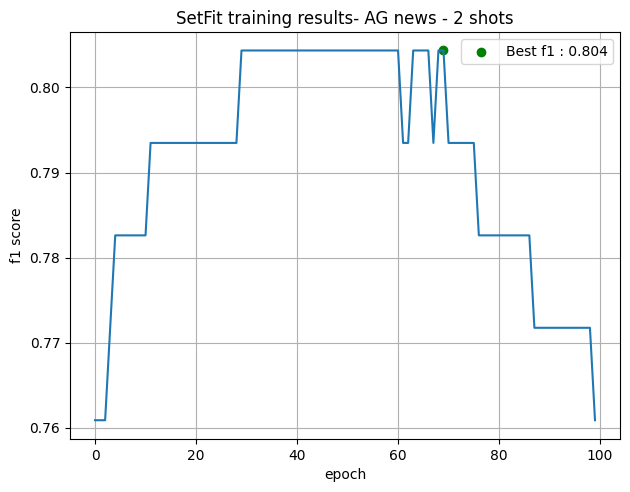

In [92]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 2 shots")

In [93]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 131.27it/s]


In [94]:
f1

tensor(0.7870, device='cuda:0')

## 5 shots

In [96]:
n_shots =5

In [101]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [102]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [103]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [104]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

### Training classifier 

In [105]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [107]:
embedding_model = SentenceTransformer("peulsilva/phrase-bert-setfit-300shots-yahoo_answers",
                            cache_folder = '/Data/pedro.silva/').to(device)
in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [108]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=10,
    save = False
)

f1 score: 0.684848427772522
metric: 0.7522643799361626
tensor([[563,  37],
        [ 67, 113]], device='cuda:0')


In [109]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [110]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [111]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [112]:
from src.utils import FocalLoss

In [113]:

_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [114]:


# embedding_model = trainer.best_model


history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    # loss_fn= FocalLoss(alpha,2),
    clf = CLF(in_features, num_classes),
    embedding_model=embedding_model,
    n_epochs=100,
    lr = 1e-4
)

---------Epoch: 41-----------
f1 score: 0.8152173757553101
tensor([[20,  3,  0,  0],
        [ 0, 22,  1,  0],
        [ 0,  0, 20,  3],
        [ 9,  0,  1, 13]], device='cuda:0')


 60%|██████    | 12/20 [00:00<00:00, 111.02it/s]


KeyboardInterrupt: 

In [ ]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [ ]:
best_epoch

14

Text(0.5, 1.0, 'SetFit training results- AG news - 2 shots')

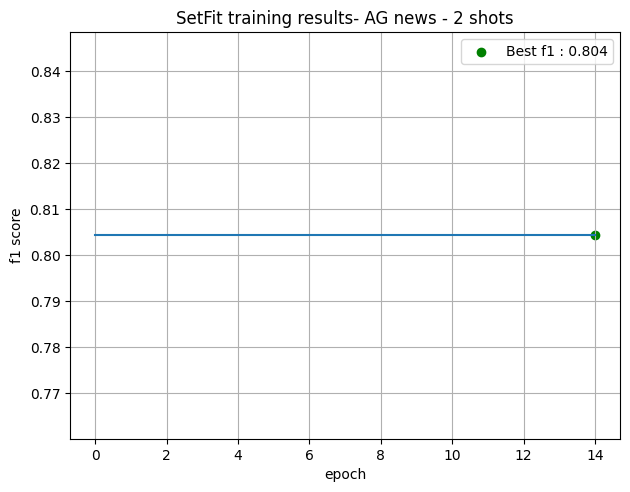

In [ ]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 2 shots")

In [115]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 130.49it/s]


In [116]:
f1

tensor(0.8090, device='cuda:0')

## 10 shots

In [117]:
n_shots = 10

In [118]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [119]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [120]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [121]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

### Training classifier 

In [122]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [123]:
embedding_model = SentenceTransformer("peulsilva/phrase-bert-setfit-300shots-yahoo_answers",
                            cache_folder = '/Data/pedro.silva/').to(device)
in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [125]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=5,
    save = False
)

f1 score: 0.7236467003822327
metric: 0.8011345642253669
tensor([[556,  44],
        [ 53, 127]], device='cuda:0')


In [126]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [127]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [128]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [129]:
from src.utils import FocalLoss

In [130]:

_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [133]:


# embedding_model = trainer.best_model


history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    # loss_fn= FocalLoss(alpha,2),
    clf = CLF(in_features, num_classes).to(device),
    embedding_model=embedding_model,
    n_epochs=20,
    lr = 1e-3
)

---------Epoch: 19-----------
f1 score: 0.8478260040283203
tensor([[20,  3,  0,  0],
        [ 0, 22,  1,  0],
        [ 0,  0, 23,  0],
        [ 9,  0,  1, 13]], device='cuda:0')


In [134]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [135]:
best_epoch

10

Text(0.5, 1.0, 'SetFit training results- AG news - 2 shots')

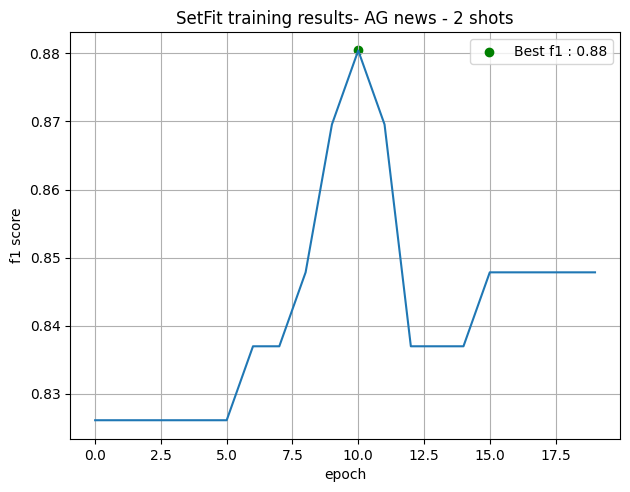

In [136]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 2 shots")

In [137]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 128.86it/s]


In [138]:
f1

tensor(0.8350, device='cuda:0')